Code for Graphs that I will make for my final submission.
==============================
There may be some repeats of graphs made in other documents. However, this notebook was made after I realized my mistake with the data, hence it seems reseaoanble to start over and make the graphs again.

# Contents:
- [Preliminary](#Preliminary)
- [Predicted vs Actual](#Predicted-vs-Actual)
- [d180 over Time for each Station](#d180-over-Time-for-each-Station)
- [Residuals](#Residuals)

# Preliminary

### Setup
Importing necessary libraries and setting colour palette and theme for the graphs.

In [15]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# Set the SeaBorn theme to persist across plots
sns.set_theme(style="darkgrid",
              palette="hls")
palette = sns.color_palette("hls", 8)
palette

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.7612000000000001, 0.33999999999999997),
 (0.5688000000000001, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.5012000000000001),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.33999999999999997, 0.43879999999999986, 0.86),
 (0.6311999999999998, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.6987999999999996)]

### Data
Reading the data and modyfying it to be used for the graphs and is easier access.

In [17]:
# Load in orginal isodata (the training data)
stationData = pd.read_csv('Isoscape_Data.csv')

# Extract only the stations and their coordinates
stations = stationData[['Station', 'Lat', 'Long']].drop_duplicates()
stationsList = stations['Station'].tolist()

stations = stations.set_index('Station')

In [18]:
# Load in results and isoP
results = pd.read_csv('results_test.csv')
isoP = pd.read_csv('isoP_Output.csv')
results.rename(columns={'Precipitation (kg/m^2/s)': 'Precip',
                        'Temperature (K)': 'Temp'}, inplace=True)

# Go through results and take Year and Day of Year [Day] into one Date column
results['Date'] = pd.to_datetime(results['Year'].astype(str) + results['Day'].astype(str).str.zfill(3), format='%Y%j')
results.drop(columns=['Year', 'Day'], inplace=True)
# Set the results Date to be at first of every month rather than the 2nd
results['Date'] = results['Date'] - pd.Timedelta(days=1)

# Go through isoP and take Year and Month into one Date column
isoP['Date'] = pd.to_datetime(isoP['Year'].astype(str) + isoP['Month'].astype(str).str.zfill(2), format='%Y%m')
isoP.drop(columns=['Year', 'Month'], inplace=True)

# Subset the isoP data to start from the first date in the results data
isoP = isoP[isoP['Date'] >= results['Date'].min()]

In [19]:
# Add Station to results and isoP via similar coordinates
for station in stationsList:
    lat = stations.loc[station, 'Lat']
    long = stations.loc[station, 'Long']

    # Find every station that is the same coordinates
    results.loc[results['Lat'] == lat, 'Station'] = station
    results.loc[results['Long'] == long, 'Station'] = station
    isoP.loc[isoP['Lat'] == lat, 'Station'] = station
    isoP.loc[isoP['Lon'] == long, 'Station'] = station


In [20]:
# Combining the results and isoP data
# Take all rows in isoP that have a coreesponding date and station in results and merge them creating a new dataframe
df = pd.merge(results, isoP, on=['Date', 'Station'], how='left')


# Reorder columns and removing some
df = df[['Station', 'Lat_x', 'Lon', 'Date', 'Temp', 'Precip', 'Actual', 'Predictions', 'isoP']].reset_index(drop=True)

# Rename columns
df.rename(columns={'Lat_x': 'Lat', 'Actual': 'Observed', 'Predictions': 'isoNet'}, inplace=True)

# Ensure that date is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

df

,Station,Lat,Lon,Date,Temp,Precip,Observed,isoNet,isoP
0,ALR,82.31,-62.17,2003-11-01,240.15315,0.000000,-34.070000,-32.946890,-33.750136
1,SNA,63.52,-116.00,2003-11-01,267.63196,0.000000,-23.350000,-26.461382,-23.157957
2,HAB,46.29,-64.15,2003-11-01,274.37950,0.000056,-8.560000,-14.373904,-9.665702
3,EUR,79.59,-85.56,2003-11-01,240.76923,0.000000,-33.200000,-32.530334,-34.351772
4,OTT,45.32,-75.67,2003-11-01,274.78870,0.000043,-11.100000,-12.844803,-11.382967
...,...,...,...,...,...,...,...,...,...
472,OTT,45.32,-75.67,2007-08-01,290.78528,0.000000,-6.524852,-9.856567,-7.082707
473,OTT,45.32,-75.67,2007-09-01,295.11430,0.000042,-10.019821,-9.911992,-8.948247
474,OTT,45.32,-75.67,2007-10-01,288.45743,0.000000,-6.432879,-11.907659,-8.380511
475,OTT,45.32,-75.67,2007-11-01,278.31640,0.000036,-10.933000,-13.835288,-12.630586


# Predicted vs Actual

In [21]:
# Calculate coefficient of determination for total
from sklearn.metrics import r2_score
r2 = r2_score(df['Observed'], df['isoNet'])

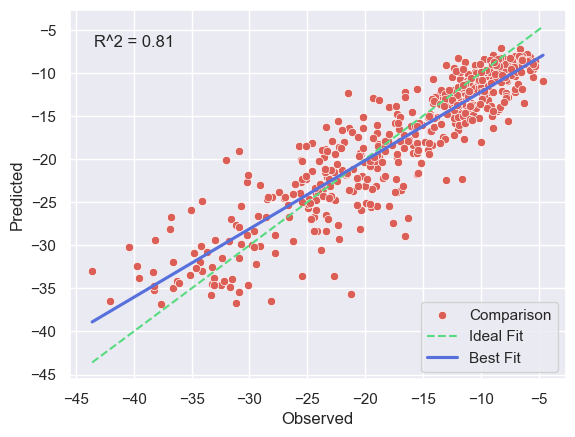

In [22]:
# Create the graph
pva = sns.scatterplot(x='Observed', y='isoNet', data=df, color=palette[0], label='Comparison')

# Add the line of ideal fit
sns.lineplot(x=df['Observed'], y=df['Observed'], linestyle='--', color=palette[3], label='Ideal Fit')

# Add the line of best fit
sns.regplot(x='Observed', y='isoNet', data=df, scatter=False, color=palette[5], ci=None, label='Best Fit')

# Annotate and add the R^2 value
pva.annotate(f'R^2 = {r2:.2f}', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=12)

# Add title and labels
pva.legend(loc='lower right')
pva.set(xlabel='Observed', ylabel='Predicted')
plt.show()
plt.close()

# d180 over Time for each Station
This graph will be a grid showing the preidcted d180 from isoNet and isoP for each station over time, as well as the actual d180.

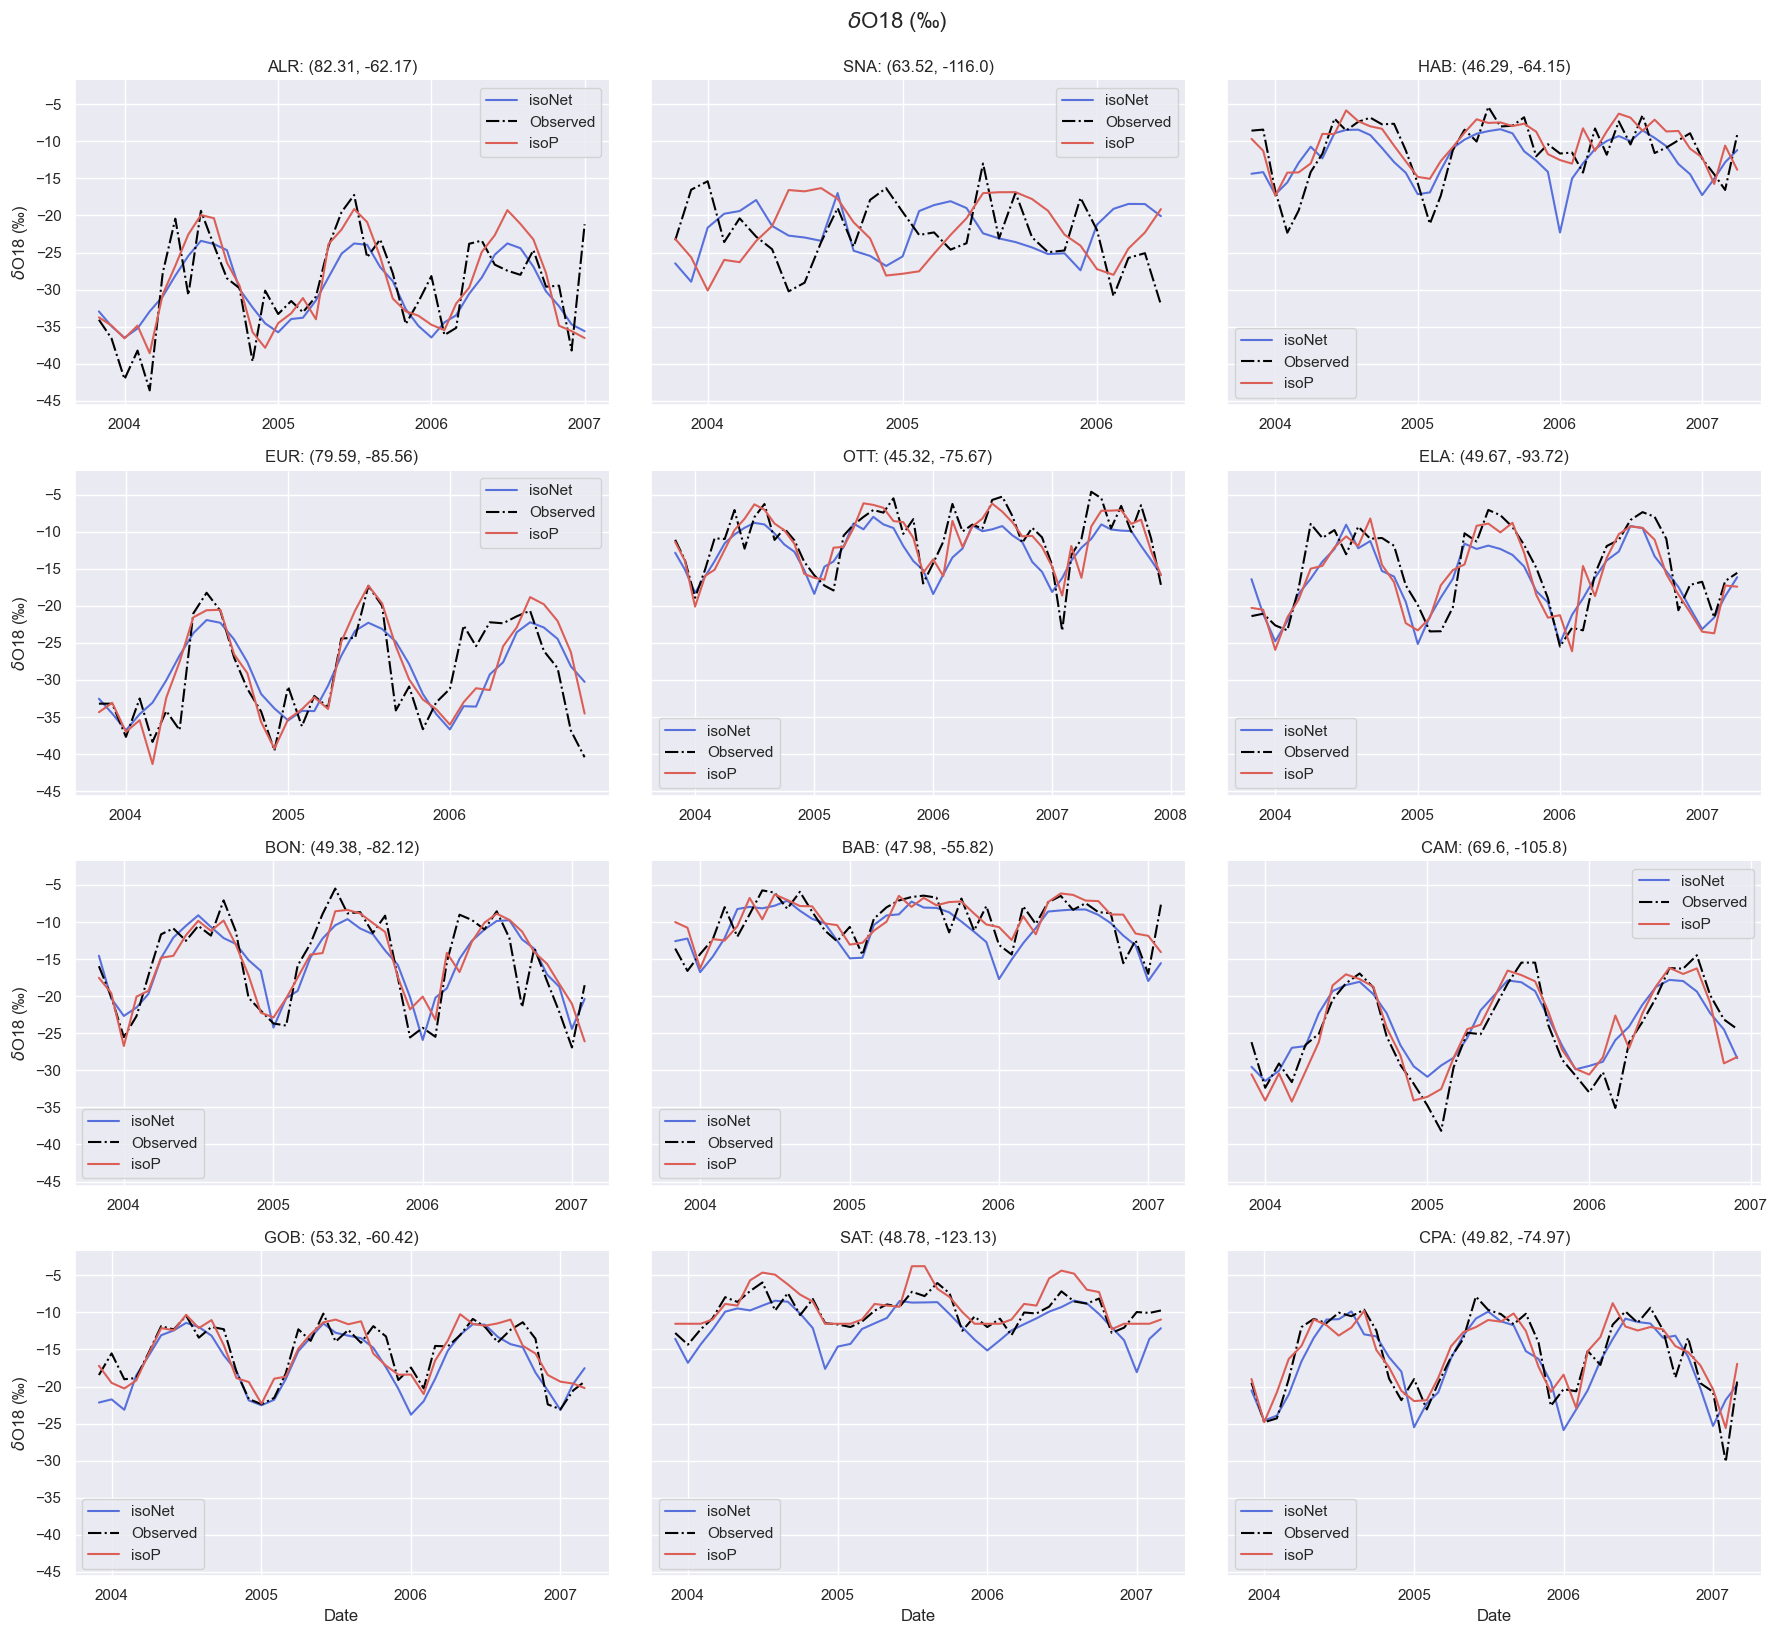

In [23]:
from matplotlib import dates as mdates

# I need to plot 3 scatter plots for each station of the d18O values over time
# Create the FacetGrid
g = sns.FacetGrid(df, col='Station', col_wrap=3, height=4, aspect=1.5, sharex=False)

# Map onto that the scatter plots for each model or observed data
g.map(sns.lineplot, 'Date', 'isoNet', label='isoNet', color=palette[5])
g.map(sns.lineplot, 'Date', 'Observed', color='black', linestyle='dashdot', label='Observed')
g.map(sns.lineplot, 'Date', 'isoP', label='isoP', color=palette[0])

# Cycle through each plot and set the x-axis to be in date format
for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.set_xlabel('Date')
    ax.legend()

    # Retrieve the station name from the pre-determined title
    station = ax.get_title().split('=')[1].strip()

    # Retrieve the station's coordinates
    lat = stations.loc[station, 'Lat']
    lon = stations.loc[station, 'Long']

    # Set the title to be the station name and coordinates in brackets
    ax.set_title(f'{station}: ({lat}, {lon})')


# Add Other stuff
g.set_axis_labels('Date', r'$\delta$O18 (‰)')
g.fig.suptitle(r'$\delta$O18 (‰)', fontsize=16, y=1.02)

plt.show()
plt.close()


# Residuals
This graph will show the residuals of the predicted d180 from isoNet and isoP for each station over time.

In [24]:
# Calculate the residuals
df['Residuals'] = df['Observed'] - df['isoNet']

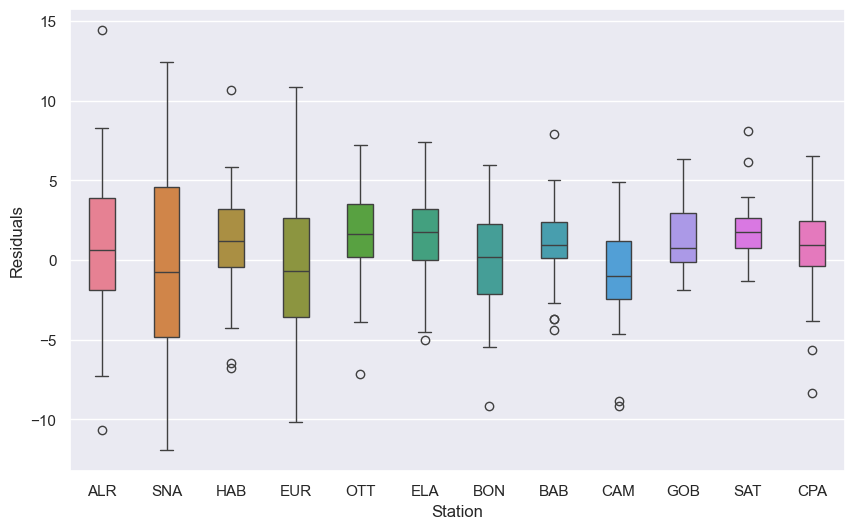

In [31]:
# Create a boxplot of the residuals for each station
plt.figure(figsize=(10, 6))
sns.boxplot(x='Station', y='Residuals', data=df, hue='Station', gap=0.5)

plt.show()
plt.close()